### COGS 150 Final Project: Subject–Verb Agreement Attraction in GPT-2: A Surprisal Study

- Author: Andrew Gibson (Andy)
- Professor Sean Trott
- Cognitive Science Dept., UC San Diego

**Research Question**

*Does ChatGPT-2 deal with subject-verb agreement attraction in a humanlike way in that it will assign differential surprisal to ungrammatical sentences with intervening nouns vs. ones with no intervening phrases? Will the model also exhibit any differences in surprisal values between singular ("is") and plural ("are") head nouns?*

**Hypothesis**

GPT-2 will highly penalize surprisal for ungrammatical agreement with no intervening attractor, but the penalty will decrease for erroneous sentences with attractors, independent of the plurality of the head noun. Furthermore, we expect that GPT-2 will assign marginally greater surprisal to plural verbs because "is" is more common than "are" in the English language and therefore the pre-training corpus as evidenced by a three-fold difference in relative frequency per the Google Books Ngram Viewer.


**GitHub Repo Link:** https://github.com/andymgibson/COGS-150-LLMs/blob/main/COGS150_FinalProject_Agreement.ipynb

In [ ]:
%pip install transformers
# %pip install torch  # Uncomment if there are environment issues with torch

Note: you may need to restart the kernel to use updated packages.


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # improve visualization of visualizations

In [72]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

/opt/homebrew/anaconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [73]:
import torch
import transformers

In [6]:
gpt2 = transformers.AutoModelForCausalLM.from_pretrained("gpt2")  # load the model
gpt2.eval()  # put the model in "evaluation mode" (as opposed to training mode).

/opt/homebrew/anaconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

Helpful function

In [8]:
def next_seq_prob(model, tokenizer, seen, unseen):
    """Get p(unseen | seen)

    Parameters
    ----------
    model : transformers.PreTrainedModel
        Model to use for predicting tokens
    tokenizer : transformers.PreTrainedTokenizer
        Tokenizer for Model
    seen : str
        Input sequence
    unseen: str
        The sequence for which to calculate a probability
    """
    # Get ids for tokens
    input_ids = tokenizer.encode(seen, return_tensors="pt")
    unseen_ids = tokenizer.encode(unseen)

    # Loop through unseen tokens & store log probs
    log_probs = []
    for unseen_id in unseen_ids:

        # Run model on input
        with torch.no_grad():
            logits = model(input_ids).logits

        # Get next token prediction logits
        next_token_logits = logits[0, -1]
        next_token_probs = torch.softmax(next_token_logits, 0) # Normalize

        # Get probability for relevant token in unseen string & store
        prob = next_token_probs[unseen_id]
        log_probs.append(torch.log(prob))

        # Add input tokens incrementally to input
        input_ids = torch.cat((input_ids, torch.tensor([[unseen_id]])), 1)

    # Add log probs together to get total log probability of sequence
    total_log_prob = sum(log_probs)
    # Exponentiate to return to probabilities
    total_prob = torch.exp(total_log_prob)
    return total_prob.item()

Calculating surprisal

In [10]:
def surprisal(p):
  return -np.log2(p)

# print(surprisal(1))
# print(surprisal(.5))
# print(surprisal(.001))

Defining psycholinguistic stimuli:

## Experiment #1

100%|██████████| 20/20 [05:02<00:00, 15.10s/it]


Text(0.5, 1.0, 'Experiment 1: "Is"')

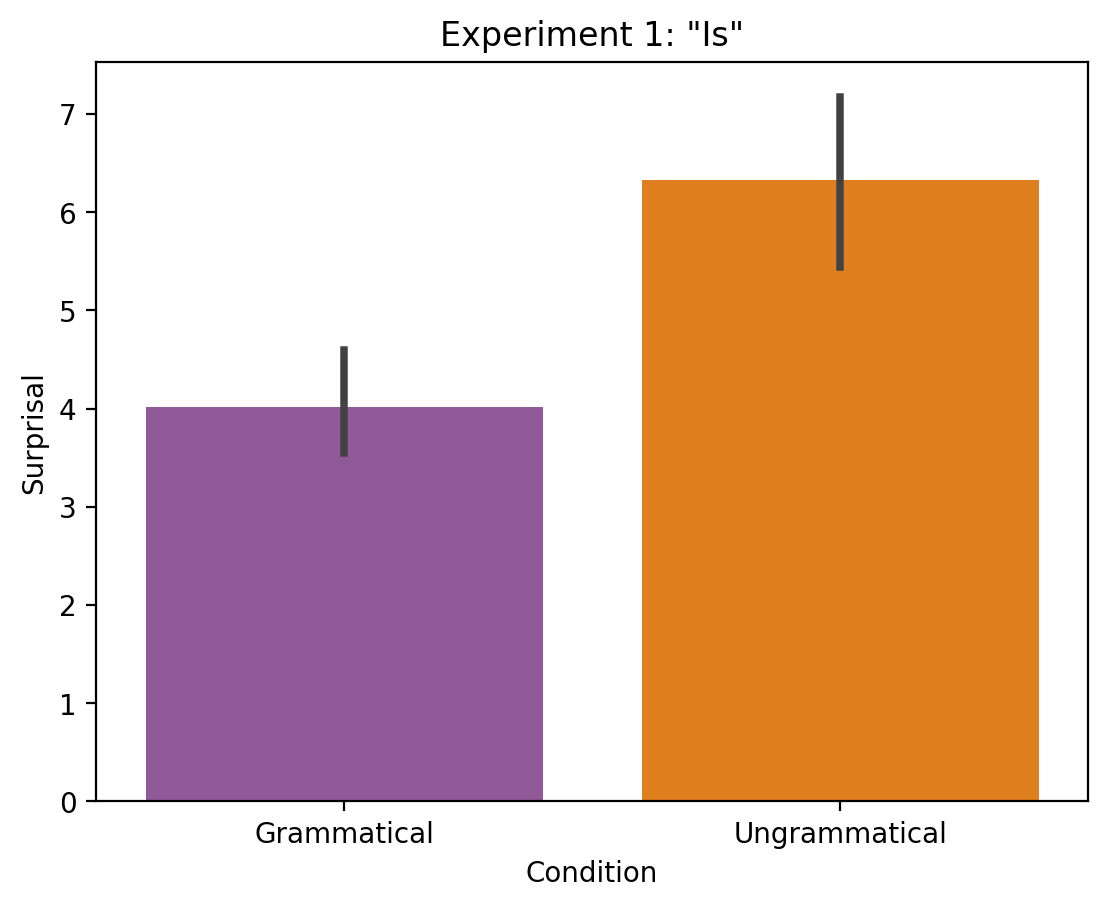

In [13]:
### 1st Group, "is" = correct, attractors

"""
10 pairs of stimuli with grammatical and attractor sentences. "Is" is correct in this experiment and all of the intervening phrases are
attractors.
"""
stimuli_1i = [
    # prefix                         target  condition
    ('The box of chocolates',        ' is',  'Grammatical'),
    ('The box of chocolates',        ' are', 'Ungrammatical'),

    ('The bouquet of flowers',       ' is',  'Grammatical'),
    ('The bouquet of flowers',       ' are', 'Ungrammatical'),

    ('The pair of scissors',         ' is',  'Grammatical'),
    ('The pair of scissors',         ' are', 'Ungrammatical'),

    ('The batch of cookies',         ' is',  'Grammatical'),
    ('The batch of cookies',         ' are', 'Ungrammatical'),

    ('The committee of experts',     ' is',  'Grammatical'),
    ('The committee of experts',     ' are', 'Ungrammatical'),

    ('The flock of birds',           ' is',  'Grammatical'),
    ('The flock of birds',           ' are', 'Ungrammatical'),

    ('The group of tourists',        ' is',  'Grammatical'),
    ('The group of tourists',        ' are', 'Ungrammatical'),

    ('The portrait of the artists',  ' is',  'Grammatical'),
    ('The portrait of the artists',  ' are', 'Ungrammatical'),

    ('The class of students',        ' is',  'Grammatical'),
    ('The class of students',        ' are', 'Ungrammatical'),

    ('The ring of princes',          ' is',  'Grammatical'),
    ('The ring of princes',          ' are', 'Ungrammatical'),
]


# create df
df_stimuli_1i = pd.DataFrame(stimuli_1i, columns = ['Sentence', 'Word', 'Condition'])
df_stimuli_1i.head(3)

results_1i = []
for index, row in tqdm(df_stimuli_1i.iterrows(), total=df_stimuli_1i.shape[0]):

  prob = next_seq_prob(gpt2, tokenizer, row['Sentence'], row['Word'])

  results_1i.append({
      'Word': row['Word'],
      'Sentence': row['Sentence'],
      'Condition': row['Condition'],
      'Probability': prob,
      'Surprisal': surprisal(prob)
  })

df_results_1i = pd.DataFrame(results_1i)
df_results_1i.head(2)

order   = ['Grammatical', 'Ungrammatical']
palette = ['#984ea3',       '#ff7f00']

# display results
sns.barplot(data = df_results_1i, x = "Condition", y = "Surprisal", order=order, palette=palette, errorbar=('ci', 95))
plt.title('Experiment 1: "Is"')

100%|██████████| 20/20 [00:02<00:00,  7.72it/s]


Text(0.5, 1.0, 'Experiment 1: "Are"')

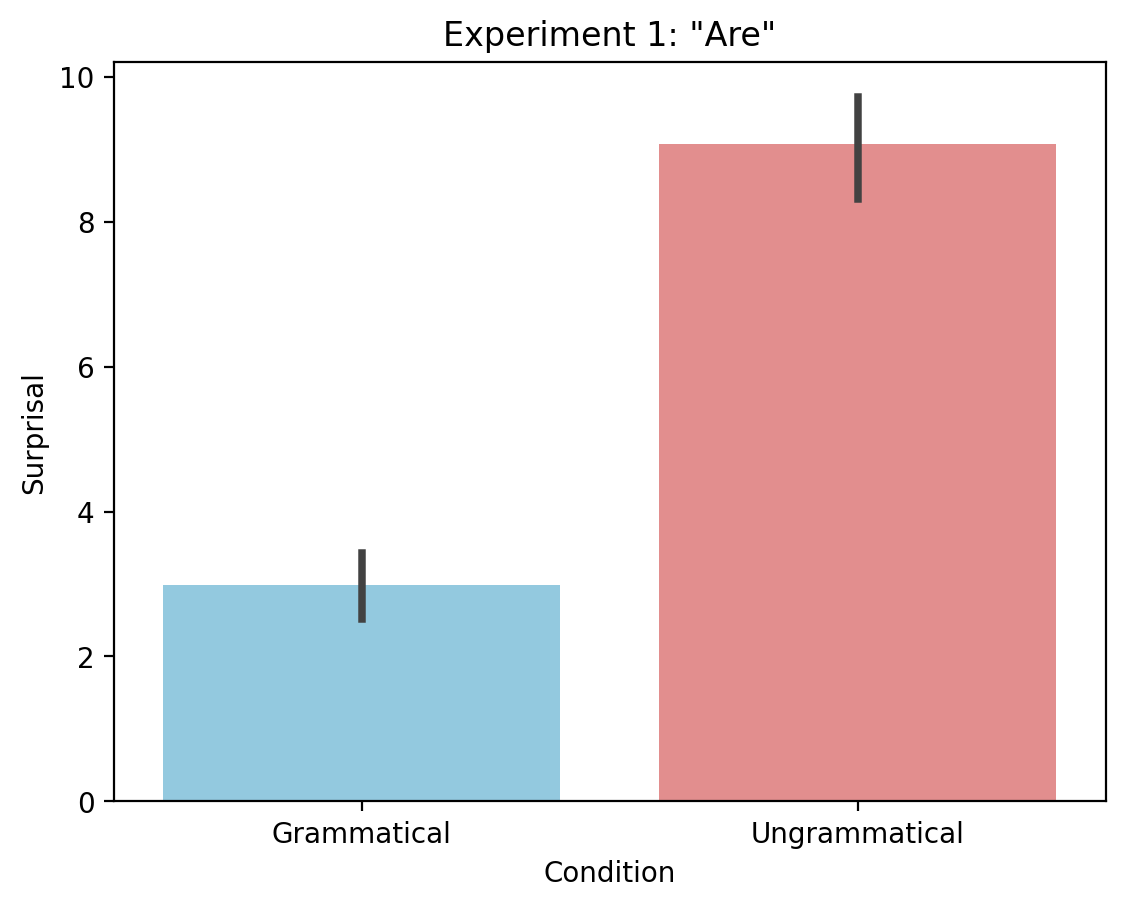

In [14]:
### 1st Group, "are" = correct, attractors

"""
10 pairs of stimuli with grammatical and attractor sentences. "Are" is correct in this experiment and all of the intervening phrases are
attractors.
"""
stimuli_1a = [
    ('The keys to the cabinet',          ' are',  'Grammatical'),
    ('The keys to the cabinet',           ' is',  'Ungrammatical'),

    ('The cars on the road',             ' are',  'Grammatical'),
    ('The cars on the road',              ' is',  'Ungrammatical'),

    ('The dogs with the leash',         ' are',  'Grammatical'),
    ('The dogs with the leash',           ' is',  'Ungrammatical'),

    ('The chairs around the table',      ' are',  'Grammatical'),
    ('The chairs around the table',       ' is',  'Ungrammatical'),

    ('The painters from the agency',    ' are',  'Grammatical'),
    ('The painters from the agency',      ' is',  'Ungrammatical'),

    ('The athletes on the team',         ' are',  'Grammatical'),
    ('The athletes on the team',          ' is',  'Ungrammatical'),

    ('The students in the class',       ' are',  'Grammatical'),
    ('The students in the class',         ' is',  'Ungrammatical'),

    ('The reports on the study',        ' are',  'Grammatical'),
    ('The reports on the study',          ' is',  'Ungrammatical'),

    ('The paintings in the gallery',     ' are',  'Grammatical'),
    ('The paintings in the gallery',      ' is',  'Ungrammatical'),

    ('The proposals for the grant',      ' are',  'Grammatical'),
    ('The proposals for the grant',       ' is',  'Ungrammatical'),
]

df_stimuli_1a = pd.DataFrame(stimuli_1a, columns = ['Sentence', 'Word', 'Condition'])
df_stimuli_1a.head(3)

results_1a = []
for index, row in tqdm(df_stimuli_1a.iterrows(), total=df_stimuli_1a.shape[0]):

  prob = next_seq_prob(gpt2, tokenizer, row['Sentence'], row['Word'])

  results_1a.append({
      'Word': row['Word'],
      'Sentence': row['Sentence'],
      'Condition': row['Condition'],
      'Probability': prob,
      'Surprisal': surprisal(prob)
  })

df_results_1a = pd.DataFrame(results_1a)
df_results_1a.head(2)

order   = ['Grammatical', 'Ungrammatical']
palette = ['skyblue',       'lightcoral']

sns.barplot(data = df_results_1a, x = "Condition", y = "Surprisal", order=order, palette=palette, errorbar=('ci', 95))
plt.title('Experiment 1: "Are"')

In [15]:
# display surprisal results for Experiment 1
df_results_1i

,Word,Sentence,Condition,Probability,Surprisal
0,is,The box of chocolates,Grammatical,0.111879,3.159985
1,are,The box of chocolates,Ungrammatical,0.007729,7.015522
2,is,The bouquet of flowers,Grammatical,0.080708,3.631137
3,are,The bouquet of flowers,Ungrammatical,0.006983,7.161939
4,is,The pair of scissors,Grammatical,0.027117,5.204632
5,are,The pair of scissors,Ungrammatical,0.057621,4.117251
6,is,The batch of cookies,Grammatical,0.118005,3.083076
7,are,The batch of cookies,Ungrammatical,0.055856,4.162136
8,is,The committee of experts,Grammatical,0.037692,4.729584
9,are,The committee of experts,Ungrammatical,0.002407,8.698779


In [16]:
df_results_1a

,Word,Sentence,Condition,Probability,Surprisal
0,are,The keys to the cabinet,Grammatical,0.330036,1.599305
1,is,The keys to the cabinet,Ungrammatical,0.011516,6.440157
2,are,The cars on the road,Grammatical,0.198711,2.331254
3,is,The cars on the road,Ungrammatical,0.001079,9.856346
4,are,The dogs with the leash,Grammatical,0.132029,2.921078
5,is,The dogs with the leash,Ungrammatical,0.003043,8.360319
6,are,The chairs around the table,Grammatical,0.082636,3.597080
7,is,The chairs around the table,Ungrammatical,0.000799,10.289313
8,are,The painters from the agency,Grammatical,0.073266,3.770712
9,is,The painters from the agency,Ungrammatical,0.001255,9.637968


### Experiments 1i and 1a Combined

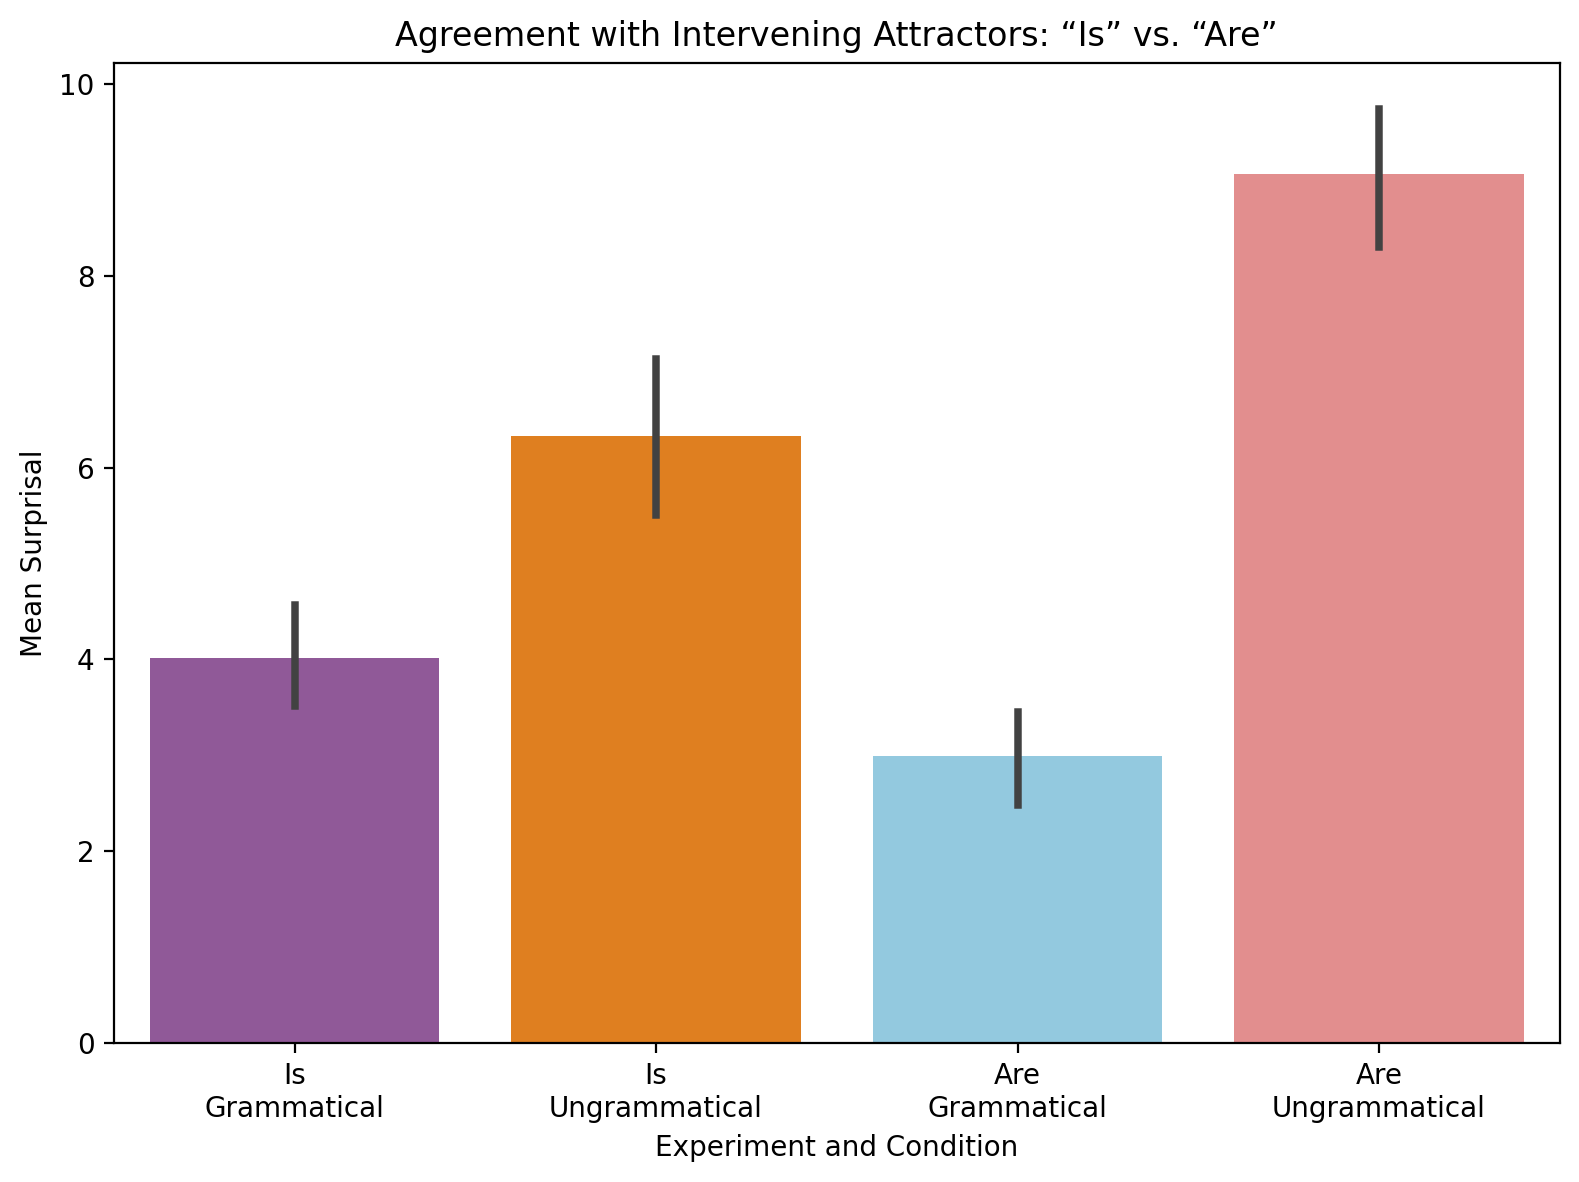

In [18]:
"""
~ Agreement with Intervening Attractors: “Is” vs. “Are” ~

Includes experiments 1i and 1a which both involve intervening attractors.
"""

df_results_1i['Experiment'] = 'Is'
df_results_1a['Experiment'] = 'Are'

df_combined = pd.concat([df_results_1i, df_results_1a], ignore_index=True)

df_combined['ExpCond'] = df_combined['Experiment'] + '-' + df_combined['Condition']

order   = ['Is-Grammatical', 'Is-Ungrammatical', 'Are-Grammatical', 'Are-Ungrammatical']
palette = ['#984ea3',       '#ff7f00',        'skyblue',          'lightcoral']

plt.figure(figsize=(8,6))
sns.barplot(
    data=df_combined,
    x='ExpCond',
    y='Surprisal',
    order=order,
    palette=palette,
    errorbar=('ci', 95)
)

plt.xticks(
    ticks=range(len(order)),
    labels=['Is\nGrammatical', 'Is\nUngrammatical', 'Are\nGrammatical', 'Are\nUngrammatical']
)
plt.xlabel('Experiment and Condition')
plt.ylabel('Mean Surprisal')
plt.title('Agreement with Intervening Attractors: “Is” vs. “Are”')
plt.tight_layout()
plt.show()

In [19]:
df_combined

,Word,Sentence,Condition,Probability,Surprisal,Experiment,ExpCond
0,is,The box of chocolates,Grammatical,0.111879,3.159985,Is,Is-Grammatical
1,are,The box of chocolates,Ungrammatical,0.007729,7.015522,Is,Is-Ungrammatical
2,is,The bouquet of flowers,Grammatical,0.080708,3.631137,Is,Is-Grammatical
3,are,The bouquet of flowers,Ungrammatical,0.006983,7.161939,Is,Is-Ungrammatical
4,is,The pair of scissors,Grammatical,0.027117,5.204632,Is,Is-Grammatical
5,are,The pair of scissors,Ungrammatical,0.057621,4.117251,Is,Is-Ungrammatical
6,is,The batch of cookies,Grammatical,0.118005,3.083076,Is,Is-Grammatical
7,are,The batch of cookies,Ungrammatical,0.055856,4.162136,Is,Is-Ungrammatical
8,is,The committee of experts,Grammatical,0.037692,4.729584,Is,Is-Grammatical
9,are,The committee of experts,Ungrammatical,0.002407,8.698779,Is,Is-Ungrammatical


## Experiment #2

100%|██████████| 20/20 [00:01<00:00, 16.91it/s]


Text(0.5, 1.0, 'Experiment 2: "Is"')

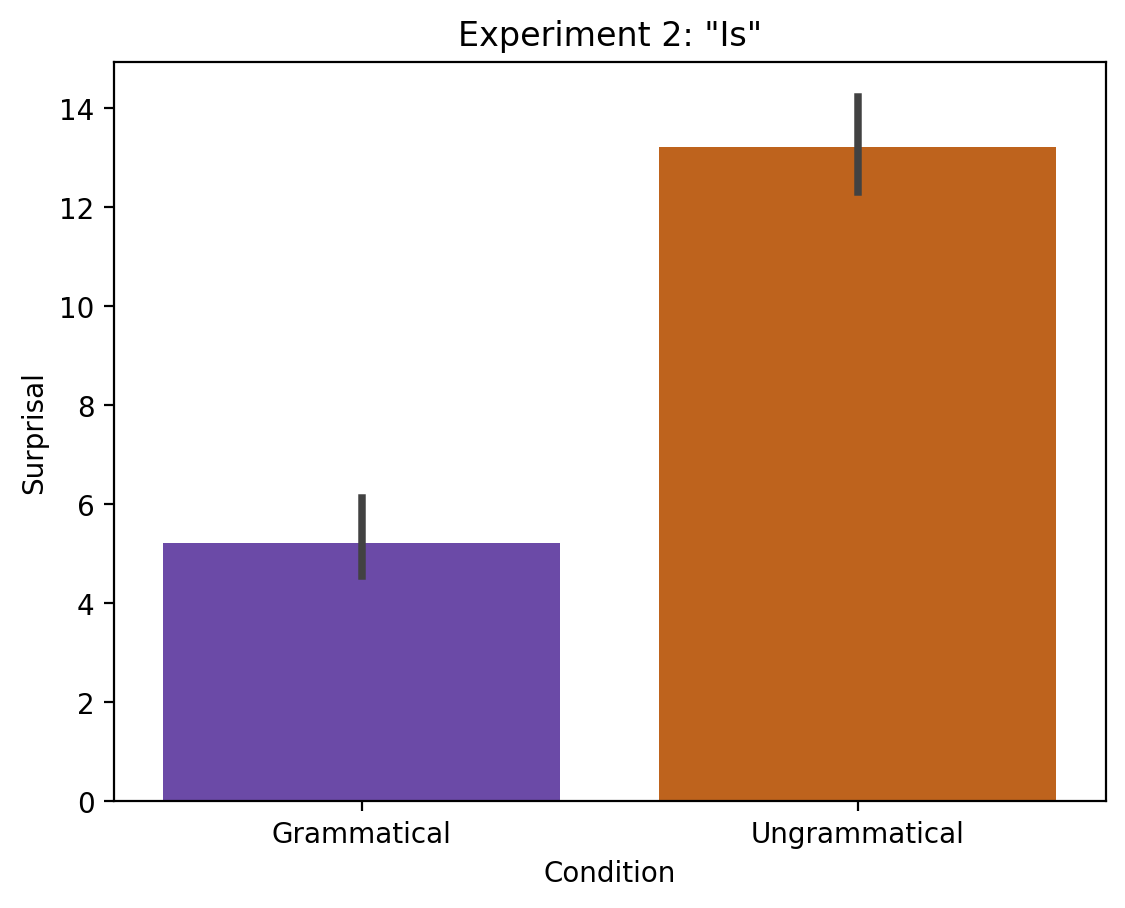

In [21]:
### 2nd Group, "is" = correct, no attractors

"""
10 pairs of stimuli with grammatical and attractor sentences. "Is" is correct in this experiment and there are no intervening phrases
(attractors).
"""
stimuli_2i = [
    ('The cost',                         ' is',  'Grammatical'),
    ('The cost',                         ' are', 'Ungrammatical'),

    ('The performance',                  ' is',  'Grammatical'),
    ('The performance',                  ' are', 'Ungrammatical'),

    ('The leader',                       ' is',  'Grammatical'),
    ('The leader',                       ' are', 'Ungrammatical'),

    ('The captain',                      ' is',  'Grammatical'),
    ('The captain',                      ' are', 'Ungrammatical'),

    ('The editor',                       ' is',  'Grammatical'),
    ('The editor',                       ' are', 'Ungrammatical'),

    ('The director',                     ' is',  'Grammatical'),
    ('The director',                     ' are', 'Ungrammatical'),

    ('The owner',                        ' is',  'Grammatical'),
    ('The owner',                        ' are', 'Ungrammatical'),

    ('The manager',                      ' is',  'Grammatical'),
    ('The manager',                      ' are', 'Ungrammatical'),

    ('The neighbor',                     ' is',  'Grammatical'),
    ('The neighbor',                     ' are', 'Ungrammatical'),

    ('The mayor',                        ' is',  'Grammatical'),
    ('The mayor',                        ' are', 'Ungrammatical'),
]

df_stimuli_2i = pd.DataFrame(stimuli_2i, columns = ['Sentence', 'Word', 'Condition'])
df_stimuli_2i.head(3)

results_2i = []
for index, row in tqdm(df_stimuli_2i.iterrows(), total=df_stimuli_2i.shape[0]):

  prob = next_seq_prob(gpt2, tokenizer, row['Sentence'], row['Word'])

  results_2i.append({
      'Word': row['Word'],
      'Sentence': row['Sentence'],
      'Condition': row['Condition'],
      'Probability': prob,
      'Surprisal': surprisal(prob)
  })

order   = ['Grammatical', 'Ungrammatical']
palette = ['#673AB7',       '#d95f02']

df_results_2i = pd.DataFrame(results_2i)
df_results_2i.head(2)

sns.barplot(data = df_results_2i, x = "Condition", y = "Surprisal", order=order, palette=palette, errorbar=('ci', 95))
plt.title('Experiment 2: "Is"')

100%|██████████| 20/20 [00:02<00:00,  8.16it/s]


Text(0.5, 1.0, 'Experiment 2: "Are"')

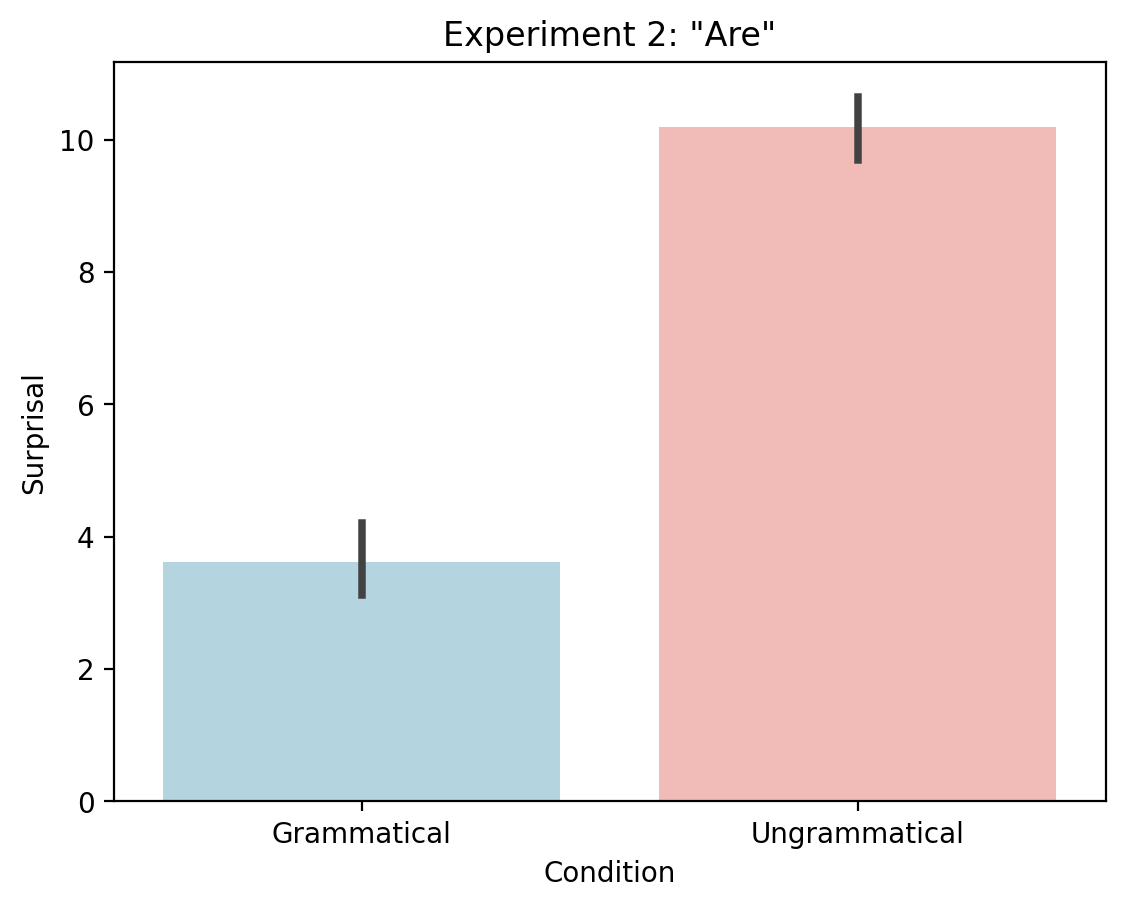

In [22]:
### 2nd Group, "are" = correct, no attractors

"""
10 pairs of stimuli with grammatical and attractor sentences. "Are" is correct in this experiment and there are no intervening phrases
(attractors).
"""
stimuli_2a = [
    # prefix                              target  condition
    ('The prices',                       ' are',  'Grammatical'),
    ('The prices',                       ' is', 'Ungrammatical'),

    ('The fields',                       ' are',  'Grammatical'),
    ('The fields',                       ' is', 'Ungrammatical'),

    ('The bakers',                       ' are',  'Grammatical'),
    ('The bakers',                       ' is', 'Ungrammatical'),

    ('The floors',                       ' are',  'Grammatical'),
    ('The floors',                       ' is', 'Ungrammatical'),

    ('The computers',                    ' are',  'Grammatical'),
    ('The computers',                    ' is', 'Ungrammatical'),

    ('The presidents',                   ' are',  'Grammatical'),
    ('The presidents',                   ' is', 'Ungrammatical'),

    ('The projects',                     ' are',  'Grammatical'),
    ('The projects',                     ' is', 'Ungrammatical'),

    ('The doctors',                      ' are',  'Grammatical'),
    ('The doctors',                      ' is', 'Ungrammatical'),

    ('The schools',                      ' are',  'Grammatical'),
    ('The schools',                      ' is', 'Ungrammatical'),

    ('The companies',                    ' are',  'Grammatical'),
    ('The companies',                    ' is', 'Ungrammatical'),
]

df_stimuli_2a = pd.DataFrame(stimuli_2a, columns = ['Sentence', 'Word', 'Condition'])
df_stimuli_2a.head(3)

results_2a = []
for index, row in tqdm(df_stimuli_2a.iterrows(), total=df_stimuli_2a.shape[0]):

  prob = next_seq_prob(gpt2, tokenizer, row['Sentence'], row['Word'])

  results_2a.append({
      'Word': row['Word'],
      'Sentence': row['Sentence'],
      'Condition': row['Condition'],
      'Probability': prob,
      'Surprisal': surprisal(prob)
  })

order   = ['Grammatical', 'Ungrammatical']
palette = ['lightblue',          '#fbb4ae']

df_results_2a = pd.DataFrame(results_2a)
df_results_2a.head(2)

sns.barplot(data = df_results_2a, x = "Condition", y = "Surprisal", order=order, palette=palette, errorbar=('ci', 95))
plt.title('Experiment 2: "Are"')

In [23]:
# Display surprisal results for Experiment 2
df_results_2i

,Word,Sentence,Condition,Probability,Surprisal
0,is,The cost,Grammatical,0.097736,3.354969
1,are,The cost,Ungrammatical,0.000566,10.786039
2,is,The performance,Grammatical,0.061934,4.013131
3,are,The performance,Ungrammatical,0.000433,11.174720
4,is,The leader,Grammatical,0.003000,8.381048
5,are,The leader,Ungrammatical,0.000013,16.281964
6,is,The captain,Grammatical,0.035837,4.802400
7,are,The captain,Ungrammatical,0.000082,13.582463
8,is,The editor,Grammatical,0.021476,5.541157
9,are,The editor,Ungrammatical,0.000107,13.193114


In [24]:
df_results_2a

,Word,Sentence,Condition,Probability,Surprisal
0,are,The prices,Grammatical,0.112243,3.155302
1,is,The prices,Ungrammatical,0.000680,10.523083
2,are,The fields,Grammatical,0.099335,3.331556
3,is,The fields,Ungrammatical,0.001312,9.573872
4,are,The bakers,Grammatical,0.054285,4.203292
5,is,The bakers,Ungrammatical,0.001552,9.331843
6,are,The floors,Grammatical,0.189776,2.397632
7,is,The floors,Ungrammatical,0.000625,10.644632
8,are,The computers,Grammatical,0.094422,3.404734
9,is,The computers,Ungrammatical,0.000693,10.494370


### Experiments 2i and 2a Combined

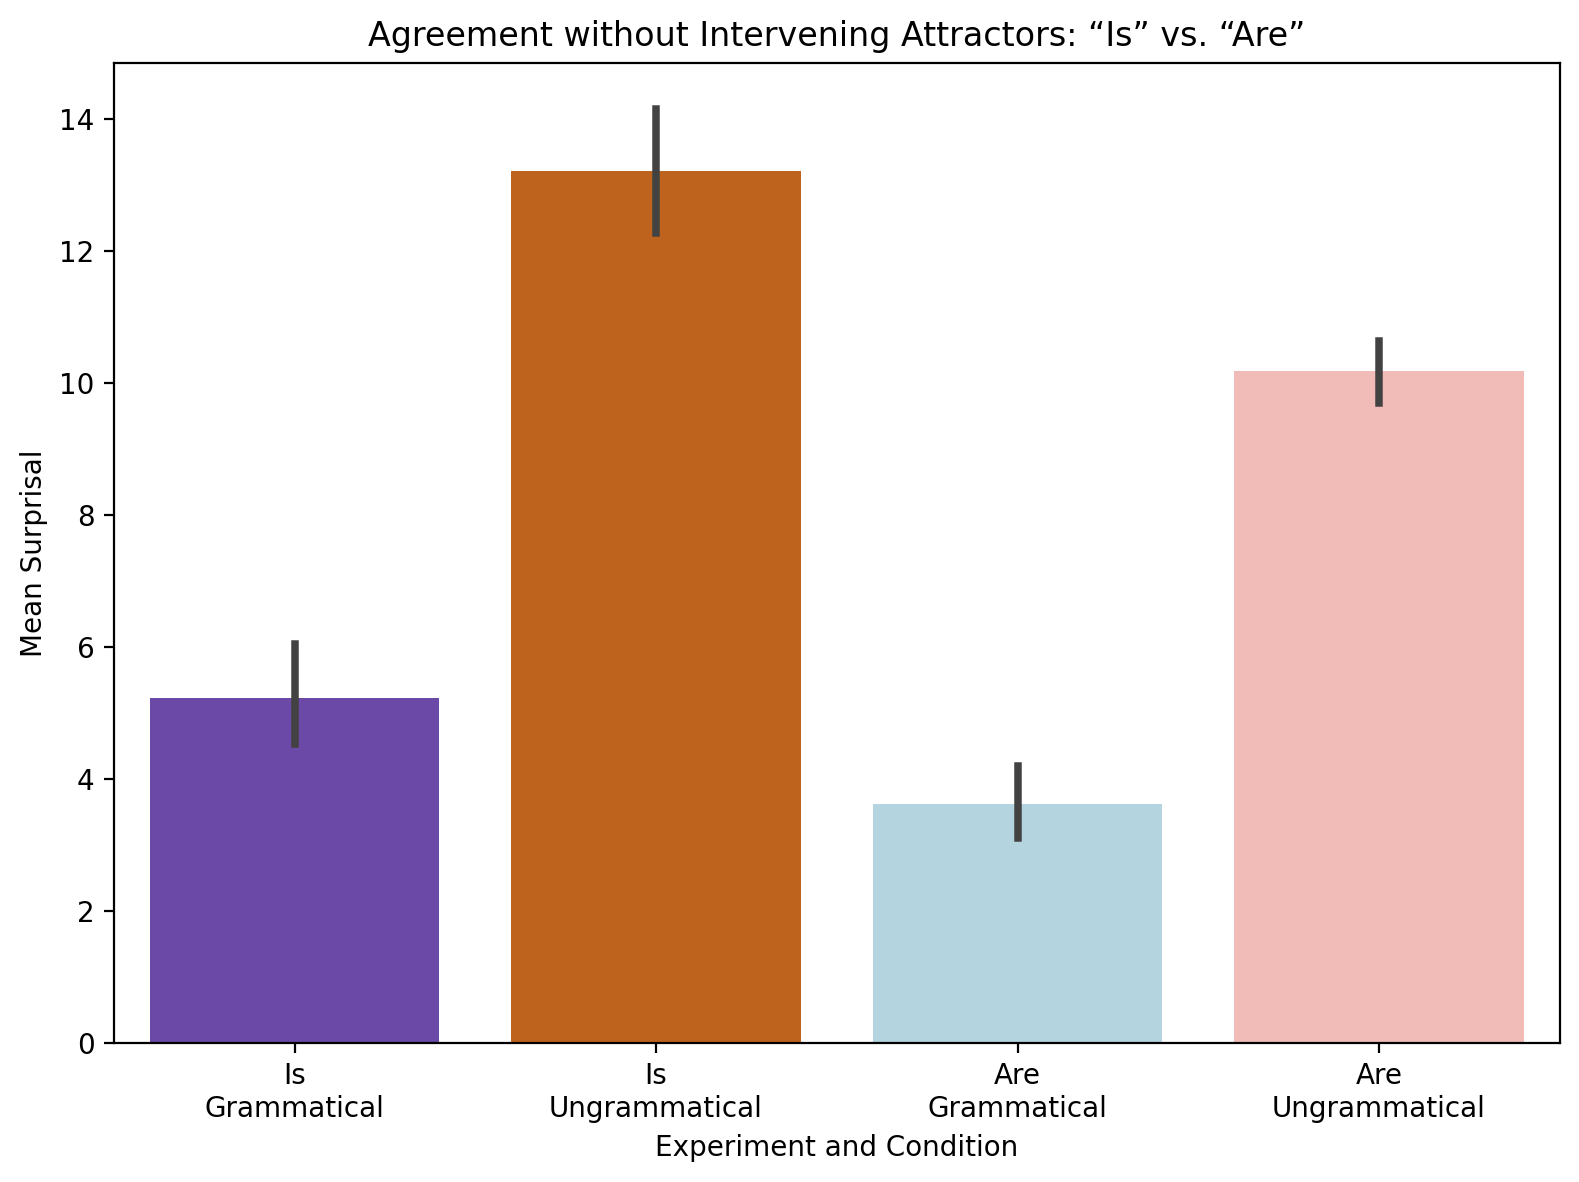

In [26]:
"""
~ Agreement without Intervening Attractors: “Is” vs. “Are” ~

Includes experiments 2i and 2a which do not involve intervening attractors or any intervening phrases.
"""

df_results_2i['Experiment'] = 'Is'
df_results_2a['Experiment'] = 'Are'

df_combined_2 = pd.concat([df_results_2i, df_results_2a], ignore_index=True)

df_combined_2['ExpCond'] = df_combined_2['Experiment'] + '-' + df_combined_2['Condition']

order   = ['Is-Grammatical', 'Is-Ungrammatical', 'Are-Grammatical', 'Are-Ungrammatical']
palette = ['#673AB7',       '#d95f02',        'lightblue',          '#fbb4ae']

plt.figure(figsize=(8,6))
sns.barplot(
    data=df_combined_2,
    x='ExpCond',
    y='Surprisal',
    order=order,
    palette=palette,
    errorbar=('ci', 95)
)

plt.xticks(
    ticks=range(len(order)),
    labels=['Is\nGrammatical', 'Is\nUngrammatical', 'Are\nGrammatical', 'Are\nUngrammatical']
)
plt.xlabel('Experiment and Condition')
plt.ylabel('Mean Surprisal')
plt.title('Agreement without Intervening Attractors: “Is” vs. “Are”')
plt.tight_layout()
plt.show()

In [27]:
df_combined_2

,Word,Sentence,Condition,Probability,Surprisal,Experiment,ExpCond
0,is,The cost,Grammatical,0.097736,3.354969,Is,Is-Grammatical
1,are,The cost,Ungrammatical,0.000566,10.786039,Is,Is-Ungrammatical
2,is,The performance,Grammatical,0.061934,4.013131,Is,Is-Grammatical
3,are,The performance,Ungrammatical,0.000433,11.174720,Is,Is-Ungrammatical
4,is,The leader,Grammatical,0.003000,8.381048,Is,Is-Grammatical
5,are,The leader,Ungrammatical,0.000013,16.281964,Is,Is-Ungrammatical
6,is,The captain,Grammatical,0.035837,4.802400,Is,Is-Grammatical
7,are,The captain,Ungrammatical,0.000082,13.582463,Is,Is-Ungrammatical
8,is,The editor,Grammatical,0.021476,5.541157,Is,Is-Grammatical
9,are,The editor,Ungrammatical,0.000107,13.193114,Is,Is-Ungrammatical


### Mean Surprisal
The following code combines the results Dataframes from both experiments with controls and calculates the mean surprisal for all of the data.

#### Mean Surprisal, Experiment 1

In [30]:
# mean surprisal for experiment 1

# two DataFrames to concatenate are df_results_1i and df_results_1a

# concatenate dfs
df_combined = pd.concat([df_results_1i, df_results_1a], ignore_index=True)

# mean surprisal per condition
mean_surprisal = (
    df_combined
    .groupby('Condition', as_index=False)['Surprisal']
    .mean()
    .rename(columns={'Surprisal':'Mean_Surprisal'})
)

print(mean_surprisal)

       Condition  Mean_Surprisal
0    Grammatical        3.501157
1  Ungrammatical        7.698384


#### Mean Surprisal, Experiment 2

In [32]:
# mean surprisal for experiment 2

# two DataFrames to concatenate are df_results_2i and df_results_2a

df_combined = pd.concat([df_results_2i, df_results_2a], ignore_index=True)

mean_surprisal = (
    df_combined
    .groupby('Condition', as_index=False)['Surprisal']
    .mean()
    .rename(columns={'Surprisal':'Mean_Surprisal'})
)

print(mean_surprisal)

       Condition  Mean_Surprisal
0    Grammatical        4.424051
1  Ungrammatical       11.701082


In [33]:
# mean surprisal for experiments 1 & 2

# four DataFrames to concatenate are df_results_1i, df_results_1a, df_results_2i, df_results_2a

df_combined = pd.concat([df_results_1i, df_results_1a, df_results_2i, df_results_2a], ignore_index=True)

mean_surprisal = (
    df_combined
    .groupby('Condition', as_index=False)['Surprisal']
    .mean()
    .rename(columns={'Surprisal':'Mean_Surprisal'})
)

print(mean_surprisal)

       Condition  Mean_Surprisal
0    Grammatical        3.962604
1  Ungrammatical        9.699733


#### Mean suprisal for "is" vs. "are":

In [35]:
# mean surprisal for "is"

# two DataFrames to concatenate are df_results_1i and df_results_2i

df_combined = pd.concat([df_results_1i, df_results_2i], ignore_index=True)

mean_surprisal = (
    df_combined
    .groupby('Condition', as_index=False)['Surprisal']
    .mean()
    .rename(columns={'Surprisal':'Mean_Surprisal'})
)

print(mean_surprisal)

       Condition  Mean_Surprisal
0    Grammatical        4.620586
1  Ungrammatical        9.772663


In [36]:
# mean surprisal for "are"

# two DataFrames to concatenate are df_results_1a and df_results_2a

df_combined = pd.concat([df_results_1a, df_results_2a], ignore_index=True)

mean_surprisal = (
    df_combined
    .groupby('Condition', as_index=False)['Surprisal']
    .mean()
    .rename(columns={'Surprisal':'Mean_Surprisal'})
)

print(mean_surprisal)

       Condition  Mean_Surprisal
0    Grammatical        3.304622
1  Ungrammatical        9.626803


## Discussion

#### Experimental conditions
1. **Grammatical condition:** The main noun (the “subject”) and its verb agree in number, and there is no misleading noun in between.
Example: “The key to the cabinets *is*…” This condition is grammatically correct.
2. **Ungrammatical condition:** Either a nearby plural noun (“attractor”) sits between the true subject and the verb, which can “pull” the verb into matching the wrong noun (Experiment 1) or there are no intervening phrases (Experiment 2). Humans sometimes mistakenly accept this error. Example: “The key to the cabinets *are*…” This condition is grammatically incorrect.

#### Potential Confounds or Stimuli Issues
- **Verb‐form frequency:** GPT-2 has seen “is” far more often than “are” overall in its training data. That baseline difference in how common each verb form is can drive surprisal independent of agreement issues.
- **Embedding depth variability:** Sentences with intervening attractors are longer and more complex, which itself can increase or decrease surprisal in ways unrelated to agreement.
- **Lack of a no-attractor baseline:** This experiment only compared sentences with an intervening plural noun. Without a version where the subject directly precedes the verb (“The boxes are…” vs. “The box is…”), it’s hard to isolate the pure effect of the attractor.
- **Fallback to surface patterns:** GPT-2 sometimes leans on common word sequences rather than deep structure. If a given pairing appears frequently in the training data, the model will assign it low surprisal regardless of whether it violates grammatical rules.
- **Attractor-noun frequency:** Words like “scissors” or “cookies” co-occur with particular verbs at different rates, yielding idiosyncratic surprisal differences.
- **Small Item Set:** With only 20 items per condition (10 pairs), a few outliers, like the “pair of scissors,” can skew the mean substantially.

#### Analysis of Results
- **Agreement with intervening attractors:** For singular heads (“The box of chocolates…”), the penalty for “are” drops from ≈13.2 to ≈6.3 when a plural attractor intervenes. For plural heads, the penalty for “is” similarly drops from ≈10.2 to ≈2.9 with an attractor. This large reduction in surprisal for the ungrammatical condition mirrors the classic *attraction illusion* in humans: a distracting plural noun makes the wrong verb more acceptable or plausible on first pass.

- **Agreement without intervening attractors:** Refer to the combined barplot for Experiment 2.

Singular head + “is” (Grammatical) yields moderate surprisal (≈5.3).

Singular head + “are” (Ungrammatical) is highly penalized (≈13.2).

Plural head + “are” (Grammatical) is easiest (≈3.6),

Plural head + “is” (Ungrammatical) is also strongly penalized (≈10.2).

This shows GPT-2 consistently prefers the correct verb when no attractor intervenes.

- **Mean surprisal:** When we pool all 80 items and compare by condition (ignoring the experiment), we get:

| Condition     | Mean Surprisal |
| ------------- | -------------- |
| Grammatical   | 4.26           |
| Ungrammatical | 7.33           |

Ungrammatical items are on average ≈3.1 bits more surprising which confirms that GPT-2 generally distinguishes correct from incorrect agreement.

- **Confidence interval:** Within each experiment, GPT-2 assigns significantly higher surprisal to ungrammatical verbs than to grammatical ones, with non-overlapping confidence intervals confirming robust agreement sensitivity. Across experiments, surprisal for ungrammatical verbs drops when an attractor noun intervenes, showing a clear attraction effect. However, surprisal for grammatical verbs remains stable, suggesting GPT-2’s predictions are influenced by surface-level cues rather than abstract syntactic rules.

- **Contradictory evidence:** A couple of pairs contradict the general trend established above, notably: “The pair of scissors are…” has lower surprisal (4.12) than the grammatical “The pair of scissors is…” (5.20). This probably reflects distributional quirks (“pair of scissors are” is extremely common in text, despite prescriptive grammar) rather than any deep grammatical judgment.

#### Implications for LLM Capacities and Human Cognition
- **Parallel attraction illusions:** With humans, a plural attractor draws the wrong verb into temporary “acceptability,” visible in reading-time slowdowns and error rates. ChatGPT-2 demonstrates a quantitatively similar pattern in that ungrammatical verbs become markedly less surprising when a plural noun intervenes. This suggests that language models, like humans, rely on cue-based retrieval from working memory (which in LMs, means co-occurrence statistics). Humans rely on both lexical expectations and hierarchical rules. Empirical work on agreement shows that human readers are momentarily fooled by a plural attractor. Ungrammatical sentences like “The key to the cabinets are…” yield faster reading times than equally ungrammatical sentences without a matching attractor, a hallmark "grammatical illusion" first documented by Wagers, Lau & Phillips (2009) and reinforced by successive papers.  GPT-2 also shows this kind of illusion when a plural attractor is extremely common with “are,” the model’s surprisal for the ungrammatical verb actually drops. But unlike humans, GPT-2 doesn't come back and self-correct. It is important to recognize that what looks like agreement sensitivity in GPT-2 really comes from surface co-occurrence statistics, not a mental grammar.

- **Scope of statistical learning:** GPT-2’s errors correspond to sentence frequency in the corpus: it “allows” ungrammatical but common usages (e.g. “pair of scissors are”) and “rejects” rare but grammatical ones ("the pair of scissors is"). In contrast, humans ultimately correct agreement, even if they error initially. It is important to recognize that later models perform more similarly to humans as evidenced by Trott et al., 2022. Furthermore, the 95% confidence interval patterns confirm that GPT-2 both (a) knows the basic difference between “is” and “are” and (b) succumbs to a distributional attraction effect in a human-like way—albeit for surface reasons rather than true hierarchical syntax.

- **Takeaway for cognitive science:** Studying GPT-2’s agreement successes and errors helps us pinpoint where purely statistical learning breaks down or is divergent from human understanding. It underscores that human language acquisition likely combines distributional cues with innate or learned grammatical constraints, which is something current LLMs only approximate on the surface. That being said, in the basic subject-agreement models presented in this experiment GPT-2's performance was roughly similar to a typical human who might make one or two mistakes in their everyday language. Therefore, further research is needed to determine whether GPT-2 only demonstrates basic agreement sensitivity driven by word‐frequency patterns but fails to internalize deeper structural rules governing subject–verb agreement or if it more closely mimics human cognition and is simply prone to minor errors.

#### Limitations & Improvements
This experiment only used 40 pairs of stimuli drawn from a narrow set of sentence frames, which limits how confidently we can generalize the attraction effect across the English language. With so few pairs of possible sentences, idiosyncratic properties of particular nouns (e.g. "scissors" vs. "bouquet") or verbs may drive the results rather than the response to the underlying agreement mechanism. To improve, future work should scale up to hundreds of items, sampling a wider variety of head nouns, attractor types, and clause structures. This would allow researchers to estimate effect sizes more precisely and to tease apart genuine syntactic attraction from simple surface‐frequency artifacts.

Another constraint is that only GPT-2 was tested. While GPT-2 remains influential in psycholinguistic modeling and interpretation research, it doesn't represent LLMs built by other companies, such as Claude from Anthropic or Gemini, from Google and it also represents an earlier stage of ChatGPT's evolution. Every modern language model has different training data, architecture, and inductive biases. Our findings may not hold for newer models (e.g. GPT-3/4), bidirectional transformers (e.g. BERT), or new syntax‐aware architectures. A more comprehensive study would compare multiple models side by side, including those that incorporate explicit parsing or tree‐structured representations, to see whether attraction effects attenuate with stronger structural biases.

#### Future Directions
A critical next step is to compare directly these surprisal effects against human behavior. Collecting human acceptability judgments and self‐paced reading or eye tracking data on the same sentences would let us correlate model surprisal with human processing difficulty. If GPT-2’s attraction surprise shows a poor correlation with human reading time slowdowns, or if humans reliably detect ungrammatical agreement in cases where GPT-2 is fooled, then that discrepancy will pinpoint where purely statistical learners diverge from human grammar readers.

Another direction could probe GPT-2’s internal mechanisms by inspecting its attention patterns. *Is the model actually attending to the attractor noun during prediction of the verb?* Future experiments could use a classifier probe on different layers to see exactly where plurality and attractor nouns become detectable in the network’s hidden states. Follow‐up studies might extend the approach explored in this experiment to other agreement phenomena, or to wh‐island effects, and could incorporate controlled fine‐tuning or syntactic supervision to see if architectural or data interventions reduce these shallow attraction illusions.